In [1]:
!pip install torch_geometric -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.0 MB/s eta 0:00:0000:0100:01


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, Batch
import numpy as np
import networkx as nx
from typing import List, Dict, Tuple
import pickle
import json
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import zipfile
import numpy as np
from PIL import Image
import glob
from pathlib import Path
import numpy as np
import networkx as nx
from scipy import ndimage
from scipy.ndimage import binary_dilation
from skimage import measure, morphology
from typing import Dict, Tuple, List, Set

In [4]:
class AnodeGraphExtractor3D:
    """
    Класс для анализа 3D-структуры анода Ni-YSZ и построения графов
    """
    def __init__(self, anode_array: np.ndarray):
        """
        Parameters:
        -----------
        anode_array : np.ndarray
            3D массив структуры анода
            Значения: 0 - пора, 1 - YSZ, 2 - Ni
        """
        self.anode_array = anode_array.astype(np.uint8)
        self.shape = anode_array.shape
        self.dimensions = len(self.shape)

        # Параметры анализа
        self.min_component_size = 1  # Минимальный размер компоненты (1x1x1) #27 (3x3x3)
        self.contact_threshold = 50.0  # Максимальное расстояние для контакта #50

    def build_phase_graph(self, phase_id: int, phase_name: str) -> nx.Graph:
        '''
        Построение графа для конкретной фазы

        Parameters:
        -----------
        phase_id : int
            Идентификатор фазы (0, 1, 2)
        phase_name : str
            Название фазы

        Returns:
        --------
        nx.Graph
            Граф фазы
        '''
        # print(f"Построение графа для фазы '{phase_name}'...")

        # Создаём бинарную маску фазы
        binary_mask = (self.anode_array == phase_id)

        # Находим связанные компоненты (26-связность для 3D)
        labeled_mask, num_components = ndimage.label(
            binary_mask,
            structure=ndimage.generate_binary_structure(3, 3)  # Полная связность 3D
        )

        # Получаем свойства регионов
        regions = measure.regionprops(labeled_mask)

        # Фильтруем мелкие компоненты (потом удалить?)
        valid_regions = []
        for i, region in enumerate(regions):
            if region.area >= self.min_component_size:
                valid_regions.append(region)

        # Создаём граф
        G = nx.Graph()

        # Добавляем вершины
        for i, region in enumerate(valid_regions):
            # Центроид региона (y, x, z) -> преобразуем в (x, y, z)
            centroid = region.centroid
            pos = (centroid[2], centroid[1], centroid[0])  # (x, y, z)

            G.add_node(
                f"{phase_name}_{i}",
                phase=phase_name,
                centroid=pos,
                centroid_original=centroid,
                volume=region.area,
                bbox=region.bbox,
                label=i+1
            )

        # Добавляем рёбра между соседними компонентами
        # Используем метод bounding box с зазором
        nodes = list(G.nodes(data=True))
        edges_added = 0

        for i in range(len(nodes)):
            for j in range(i+1, len(nodes)):
                node_i, data_i = nodes[i]
                node_j, data_j = nodes[j]

                bbox_i = data_i['bbox']  # (min_row, min_col, min_z, max_row, max_col, max_z)
                bbox_j = data_j['bbox']

                # Проверяем пересечение bounding boxes с зазором
                gap = 3  # вокселей
                intersect = True
                for dim in range(3):  # для x, y, z
                    min_i = bbox_i[dim] - gap
                    max_i = bbox_i[dim + 3] + gap
                    min_j = bbox_j[dim] - gap
                    max_j = bbox_j[dim + 3] + gap

                    if not (max_i >= min_j and max_j >= min_i):
                        intersect = False
                        break

                if intersect:
                    # Вычисляем расстояние между центрами
                    pos_i = data_i['centroid']
                    pos_j = data_j['centroid']

                    dist = np.sqrt(
                        (pos_i[0] - pos_j[0])**2 +
                        (pos_i[1] - pos_j[1])**2 +
                        (pos_i[2] - pos_j[2])**2
                    )

                    # Добавляем ребро, если расстояние меньше порога
                    if dist < self.contact_threshold * 3:  # умноженный на √3 для 3D
                        G.add_edge(node_i, node_j,
                                  weight=1.0/(dist + 1e-6),
                                  distance=dist)
                        edges_added += 1
        
        print(f'   {phase_name}: вершин: {G.number_of_nodes()}, рёбер: {G.number_of_edges()}')

        return G


    def extract_anode_structure(self) -> Dict[str, nx.Graph]:
        '''
        Анализ структуры анода

        Returns:
        --------
        Dict[str, nx.Graph]
            Словарь с 3мя графами:
            - 'pore': граф пор
            - 'YSZ': граф YSZ
            - 'Ni': граф Ni
        '''

        G_pore = self.build_phase_graph(0, 'pore')
        G_ysz = self.build_phase_graph(1, 'ysz')
        G_ni = self.build_phase_graph(2, 'ni')

        graphs = [G_pore, G_ysz, G_ni]

        return graphs

In [5]:
!gdown 1BhW7-B2m2qvWQcgndhvSjf_Gnd1_Ag2X

Downloading...
From (original): https://drive.google.com/uc?id=1BhW7-B2m2qvWQcgndhvSjf_Gnd1_Ag2X
From (redirected): https://drive.google.com/uc?id=1BhW7-B2m2qvWQcgndhvSjf_Gnd1_Ag2X&confirm=t&uuid=81dfbd41-c30e-4804-8ce8-6d6ccf285529
To: /kaggle/working/Voxels_archive_overlap=0.5.zip
100%|█████████████████████████████████████████| 295M/295M [00:01<00:00, 268MB/s]


In [6]:
input = 'Voxels_archive_overlap=0.5.zip'

dir_input = './'

os.makedirs(dir_input, exist_ok=True)

with zipfile.ZipFile(input, 'r') as zip_ref:
      print(f'unzip: {input}')
      zip_ref.extractall(dir_input)

unzip: Voxels_archive_overlap=0.5.zip


In [7]:
Graph_triplets = []
Graph_labels = []

In [8]:
datadir = Path(dir_input + '/data/')
for filepath in glob.glob(str(datadir / '*.npy')):
  print(f'Анализ файла {filepath}')
  anode_3d = np.load(filepath)
  analyzer = AnodeGraphExtractor3D(anode_3d)
  graphs = analyzer.extract_anode_structure()
  Graph_triplets.append(graphs)
  if 'degraded' in filepath:
    conditions = 'degraded'
  elif 'pristine' in filepath:
    conditions = 'pristine'

  if 'fine' in filepath:
    quality = 'fine'
  elif 'medium' in filepath:
    quality = 'medium'
  else:
    quality = 'coarse'

  Graph_labels.append(f'{conditions}_{quality}')

Анализ файла data/3D_pristine_coarse_3.npy
   pore: вершин: 94, рёбер: 25
   ysz: вершин: 169, рёбер: 60
   ni: вершин: 483, рёбер: 455
Анализ файла data/3D_degraded_medium_17.npy
   pore: вершин: 36, рёбер: 9
   ysz: вершин: 339, рёбер: 371
   ni: вершин: 537, рёбер: 557
Анализ файла data/3D_pristine_fine_23.npy
   pore: вершин: 136, рёбер: 51
   ysz: вершин: 86, рёбер: 25
   ni: вершин: 440, рёбер: 258
Анализ файла data/3D_degraded_coarse_4.npy
   pore: вершин: 38, рёбер: 10
   ysz: вершин: 226, рёбер: 193
   ni: вершин: 84, рёбер: 49
Анализ файла data/3D_degraded_coarse_3.npy
   pore: вершин: 57, рёбер: 14
   ysz: вершин: 271, рёбер: 213
   ni: вершин: 55, рёбер: 18
Анализ файла data/3D_degraded_coarse_27.npy
   pore: вершин: 49, рёбер: 10
   ysz: вершин: 409, рёбер: 438
   ni: вершин: 107, рёбер: 39
Анализ файла data/3D_pristine_coarse_9.npy
   pore: вершин: 82, рёбер: 36
   ysz: вершин: 147, рёбер: 64
   ni: вершин: 539, рёбер: 770
Анализ файла data/3D_pristine_fine_14.npy
   pore

In [9]:
len(Graph_labels)

109

In [10]:
# КОНФИГУРАЦИЯ
CONFIG = {
    # Пути к данным
    'save_dir': './models/',        # Папка для сохранения моделей
    'results_dir': './results/',    # Папка для результатов

    # Параметры модели
    'node_dim': 7,                  # Размерность признаков узла
    'hidden_dim': 256,              # Размерность скрытых слоёв
    'latent_dim': 32,               # Размерность латентного пространства
    'max_nodes': 200,               # Максимальное количество узлов на граф
    'num_conditions': 6,            # 6 классов качества анода

    # Параметры обучения
    'batch_size': 2,                # Маленький batch size для графов
    'epochs': 50,                   # Количество эпох
    'lr': 1e-3,                     # Learning rate
    'weight_decay': 1e-5,           # L2 regularization
    'kl_weight': 0.0001,            # Вес KL divergence
    'beta_annealing': True,         # Аннелинг веса KL
    'beta_start': 0.0,              # Начальное значение beta
    'beta_end': 0.001,              # Конечное значение beta
    'beta_anneal_epochs': 20,       # Эпохи аннелинга
}

In [11]:
#ПРЕОБРАЗОВАНИЕ ДАННЫХ В PyTORCH GEOMETRIC ФОРМАТ
class AnodeGraphDataset(torch.utils.data.Dataset):
    '''Датасет для трёхграфовых структур анода'''

    def __init__(self, graph_triplets: List, labels: List[str],
                 max_nodes: int = 50, node_dim: int = 7):
        self.graph_triplets = graph_triplets
        self.labels = labels
        self.max_nodes = max_nodes
        self.node_dim = node_dim

        # Маппинг меток в индексы
        self.condition_types = [
            'pristine_fine', 'pristine_medium', 'pristine_coarse',
            'degraded_fine', 'degraded_medium', 'degraded_coarse'
        ]
        self.condition_to_idx = {cond: i for i, cond in enumerate(self.condition_types)}

        # Проверяем все метки
        self.condition_indices = []
        for label in labels:
            if label in self.condition_to_idx:
                self.condition_indices.append(self.condition_to_idx[label])
            else:
                raise ValueError(f"Неизвестная метка: {label}")

    def __len__(self):
        return len(self.graph_triplets)

    def __getitem__(self, idx):
        G_pore, G_ysz, G_ni = self.graph_triplets[idx]
        condition_idx = self.condition_indices[idx]
        label = self.labels[idx]

        # Преобразуем графы в формат PyG
        pore_data = self._graph_to_pyg(G_pore, phase='pore')
        ysz_data = self._graph_to_pyg(G_ysz, phase='ysz')
        ni_data = self._graph_to_pyg(G_ni, phase='ni')

        return {
            'pore': pore_data,
            'ysz': ysz_data,
            'ni': ni_data,
            'condition': condition_idx,
            'label': label,
            'original_graphs': (G_pore, G_ysz, G_ni)  # Сохраняем оригинал для анализа
        }

    def _graph_to_pyg(self, G: nx.Graph, phase: str) -> Data:
        '''Преобразует NetworkX граф в PyG Data объект'''

        if len(G.nodes()) == 0:
            # Пустой граф
            return Data(
                x=torch.zeros((1, self.node_dim)),
                edge_index=torch.zeros((2, 0), dtype=torch.long)
            )

        # 1. Выбираем топ-N узлов по объёму
        nodes = sorted(G.nodes(data=True),
                      key=lambda x: x[1].get('volume', 0),
                      reverse=True)[:self.max_nodes]

        # 2. Извлекаем признаки узлов
        node_features = []
        node_indices = []

        for node_idx, (node_id, data) in enumerate(nodes):
            features = []

            # Объём (логарифмированный и нормализованный)
            volume = data.get('volume', 1.0)
            features.append(np.log(volume + 1) / 10.0)

            # Координаты (нормализованные к [0,1])
            centroid = data.get('centroid', (0, 0, 0))
            features.append(centroid[0] / 456.0)  # X
            features.append(centroid[1] / 456.0)  # Y
            features.append(centroid[2] / 456.0)  # Z

            # Степень узла (нормализованная)
            degree = G.degree(node_id)
            features.append(degree / 20.0)

            # Площадь поверхности (оценочная)
            surface_area = (volume ** (2/3)) * 6.0  # Для куба
            features.append(surface_area / 1000.0)

            # Фаза (one-hot)
            phase_map = {'pore': 0, 'ysz': 1, 'ni': 2}
            phase_val = phase_map.get(phase, 0)
            features.append(float(phase_val))

            node_features.append(features)
            node_indices.append(node_id)

        node_features = torch.tensor(node_features, dtype=torch.float32)

        # 3. Извлекаем рёбра (только между выбранными узлами)
        node_id_to_idx = {node_id: idx for idx, node_id in enumerate(node_indices)}
        edge_list = []

        for u, v in G.edges():
            if u in node_id_to_idx and v in node_id_to_idx:
                edge_list.append([node_id_to_idx[u], node_id_to_idx[v]])

        if edge_list:
            edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
        else:
            edge_index = torch.zeros((2, 0), dtype=torch.long)

        return Data(x=node_features, edge_index=edge_index)

def collate_anode_graphs(batch):
    '''Собирает батч из трёхграфовых структур'''
    pore_batch = Batch.from_data_list([item['pore'] for item in batch])
    ysz_batch = Batch.from_data_list([item['ysz'] for item in batch])
    ni_batch = Batch.from_data_list([item['ni'] for item in batch])

    conditions = torch.tensor([item['condition'] for item in batch], dtype=torch.long)
    labels = [item['label'] for item in batch]
    original_graphs = [item['original_graphs'] for item in batch]

    return {
        'pore': pore_batch,
        'ysz': ysz_batch,
        'ni': ni_batch,
        'conditions': conditions,
        'labels': labels,
        'original_graphs': original_graphs
    }

In [12]:
#АРХИТЕКТУРА МОДЕЛИ
class GraphEncoder(nn.Module):
    '''GNN энкодер для одного графа'''

    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)

        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = self.conv3(x, edge_index)

        # Глобальное среднее для всего графа
        x = global_mean_pool(x, batch)

        # Проекция в выходное пространство
        x = self.fc_out(x)

        return x

class ConditionalGraphEncoder(nn.Module):
    '''Энкодер для трёх графов'''

    def __init__(self, node_dim, hidden_dim, latent_dim, num_conditions):
        super().__init__()

        # Энкодеры для каждой фазы
        self.pore_encoder = GraphEncoder(node_dim, hidden_dim, hidden_dim)
        self.ysz_encoder = GraphEncoder(node_dim, hidden_dim, hidden_dim)
        self.ni_encoder = GraphEncoder(node_dim, hidden_dim, hidden_dim)

        # Кодировщик условия
        self.condition_emb = nn.Embedding(num_conditions, hidden_dim)

        # Проекция в латентное пространство
        self.fc_mu = nn.Linear(hidden_dim * 4, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim * 4, latent_dim)

        # Внимание между графами
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)

    def forward(self, pore_data, ysz_data, ni_data, conditions):
        # Кодируем каждый граф
        h_pore = self.pore_encoder(pore_data)  # [batch, hidden]
        h_ysz = self.ysz_encoder(ysz_data)    # [batch, hidden]
        h_ni = self.ni_encoder(ni_data)       # [batch, hidden]

        # Кодируем условие
        h_cond = self.condition_emb(conditions)  # [batch, hidden]

        # Применяем внимание между представлениями
        # Объединяем все представления
        h_all = torch.stack([h_pore, h_ysz, h_ni, h_cond], dim=1)  # [batch, 4, hidden]

        # Self-attention
        h_attended, _ = self.attention(h_all, h_all, h_all)
        h_attended = h_attended.mean(dim=1)  # [batch, hidden]

        # Проекция
        h_concat = torch.cat([h_pore, h_ysz, h_ni, h_cond], dim=1)

        # Сначала проецируем h_attended в пространство той же размерности, что и h_concat
        h_attended_proj = self.fc_attention(h_attended) if hasattr(self, 'fc_attention') else h_attended

        # Если размерности не совпадают, корректируем
        if h_attended_proj.size(1) != h_concat.size(1):
            # Простая линейная проекция для выравнивания размерностей
            if not hasattr(self, 'fc_attention'):
                self.fc_attention = nn.Linear(h_attended_proj.size(1), h_concat.size(1)).to(h_attended_proj.device)
                h_attended_proj = self.fc_attention(h_attended_proj)

        h_combined = 0.5 * h_concat + 0.5 * h_attended_proj

        # Параметры латентного распределения
        mu = self.fc_mu(h_combined)
        logvar = self.fc_logvar(h_combined)

        return mu, logvar

class GraphDecoder(nn.Module):
    '''Декодер для генерации одного графа'''

    def __init__(self, latent_dim, hidden_dim, node_dim, max_nodes):
        super().__init__()

        self.max_nodes = max_nodes
        self.node_dim = node_dim

        # Генерация признаков узлов
        self.node_generator = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, max_nodes * node_dim)
        )

        # Генерация матрицы смежности
        self.edge_predictor = nn.Sequential(
            nn.Linear(node_dim * 2 + latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, z):
        batch_size = z.shape[0]

        # Генерируем признаки узлов
        node_features = self.node_generator(z)  # [batch, max_nodes * node_dim]
        node_features = node_features.view(batch_size, self.max_nodes, self.node_dim)

        return node_features

    def predict_edges(self, z, node_features):
        #Предсказывает рёбра между узлами
        batch_size = z.shape[0]
        adj_matrices = []

        for b in range(batch_size):
            adj_matrix = torch.zeros((self.max_nodes, self.max_nodes))

            # Для каждой пары узлов
            for i in range(self.max_nodes):
                for j in range(i+1, self.max_nodes):
                    # Конкатенация признаков
                    pair_features = torch.cat([
                        node_features[b, i],
                        node_features[b, j],
                        z[b]
                    ])

                    # Предсказание вероятности связи
                    logit = self.edge_predictor(pair_features)
                    prob = torch.sigmoid(logit)

                    if prob > 0.5:  # Порог
                        adj_matrix[i, j] = 1
                        adj_matrix[j, i] = 1

            adj_matrices.append(adj_matrix)

        return torch.stack(adj_matrices)

class ConditionalGraphDecoder(nn.Module):
    '''Декодер для генерации трёх графов'''

    def __init__(self, latent_dim, hidden_dim, node_dim, max_nodes, num_conditions):
        super().__init__()

        # Общий декодер для признаков узлов
        self.base_decoder = GraphDecoder(latent_dim, hidden_dim, node_dim, max_nodes)

        # Проекции для разных фаз
        self.phase_projectors = nn.ModuleList([
            nn.Sequential(
                nn.Linear(node_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, node_dim)
            ) for _ in range(3)
        ])

        # Проекция условия
        self.condition_proj = nn.Embedding(num_conditions, latent_dim)

        # Проекция для смещения фазы
        self.phase_bias = nn.ParameterList([
            nn.Parameter(torch.randn(node_dim)) for _ in range(3)
        ])

    def forward(self, z, conditions):
        batch_size = z.shape[0]

        # Добавляем информацию о условии к латентному вектору
        cond_emb = self.condition_proj(conditions)
        z_conditioned = z + cond_emb

        # Генерируем базовые признаки узлов
        base_features = self.base_decoder(z_conditioned)  # [batch, max_nodes, node_dim]

        # Генерируем графы для каждой фазы
        generated_graphs = []

        for phase in range(3):
            # Проецируем для конкретной фазы
            phase_features = self.phase_projectors[phase](base_features)

            # Добавляем смещение фазы
            phase_features = phase_features + self.phase_bias[phase]

            # Предсказываем рёбра
            adj_matrix = self.base_decoder.predict_edges(z_conditioned, phase_features)

            generated_graphs.append({
                'node_features': phase_features,
                'adj_matrix': adj_matrix
            })

        return generated_graphs

class ConditionalGraphVAE(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.config = config

        # Энкодер
        self.encoder = ConditionalGraphEncoder(
            node_dim=config['node_dim'],
            hidden_dim=config['hidden_dim'],
            latent_dim=config['latent_dim'],
            num_conditions=config['num_conditions']
        )

        # Декодер
        self.decoder = ConditionalGraphDecoder(
            latent_dim=config['latent_dim'],
            hidden_dim=config['hidden_dim'],
            node_dim=config['node_dim'],
            max_nodes=config['max_nodes'],
            num_conditions=config['num_conditions']
        )

    def reparameterize(self, mu, logvar):
        '''Reparameterization trick'''
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, pore_data, ysz_data, ni_data, conditions):
        # Кодирование
        mu, logvar = self.encoder(pore_data, ysz_data, ni_data, conditions)
        z = self.reparameterize(mu, logvar)

        # Декодирование
        recon_graphs = self.decoder(z, conditions)

        return recon_graphs, mu, logvar, z

    def encode(self, pore_data, ysz_data, ni_data, conditions):
        '''Только кодирование (для инференса'''
        mu, logvar = self.encoder(pore_data, ysz_data, ni_data, conditions)
        return mu

    def decode(self, z, conditions):
        '''Только декодирование (для генерации'''
        return self.decoder(z, conditions)

In [13]:
#ФУНКЦИИ ПОТЕРЬ И МЕТРИКИ
def compute_reconstruction_loss(recon_graphs, original_data, config):
    total_loss = 0

    # Имена фаз
    phases = ['pore', 'ysz', 'ni']

    for phase_idx, phase in enumerate(phases):
        # Loss для признаков узлов
        recon_features = recon_graphs[phase_idx]['node_features']
        orig_features = original_data[phase].x

        # Выравниваем размеры
        batch_size = original_data[phase].batch.max().item() + 1

        # Переформатируем оригинальные признаки
        orig_features_list = []
        for b in range(batch_size):
            mask = (original_data[phase].batch == b)
            feat = orig_features[mask]
            # Дополняем нулями до max_nodes
            if len(feat) < config['max_nodes']:
                padding = torch.zeros((config['max_nodes'] - len(feat),
                                     config['node_dim'])).to(feat.device)
                feat = torch.cat([feat, padding], dim=0)
            elif len(feat) > config['max_nodes']:
                feat = feat[:config['max_nodes']]
            orig_features_list.append(feat)

        orig_features_padded = torch.stack(orig_features_list)

        # MSE loss для признаков
        mse_loss = F.mse_loss(recon_features, orig_features_padded)

        # Можно добавить дополнительные loss:
        # 1. Loss для степеней узлов
        # 2. Loss для распределения объёмов
        # 3. Физические ограничения

        total_loss += mse_loss

    return total_loss / 3  # Среднее по трём фазам

def kl_divergence(mu, logvar):
    '''KL divergence между q(z|x) и p(z)'''
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

class BetaScheduler:
    '''Аннелинг веса KL divergence'''

    def __init__(self, start=0.0, end=0.001, anneal_epochs=100):
        self.start = start
        self.end = end
        self.anneal_epochs = anneal_epochs
        self.current_epoch = 0

    def step(self):
        self.current_epoch += 1

    @property
    def beta(self):
        if self.current_epoch >= self.anneal_epochs:
            return self.end

        # Линейный аннелинг
        progress = self.current_epoch / self.anneal_epochs
        return self.start + (self.end - self.start) * progress

In [14]:
#ОБУЧЕНИЕ МОДЕЛИ
def train_model(config):

    print("ИНИЦИАЛИЗАЦИЯ ОБУЧЕНИЯ")

    # Создаём директории
    save_dir = Path(config['save_dir'])
    results_dir = Path(config['results_dir'])
    save_dir.mkdir(parents=True, exist_ok=True)
    results_dir.mkdir(parents=True, exist_ok=True)

    print(f"Всего образцов: {len(Graph_triplets)}")
    print(f"Размерность признаков узла: {config['node_dim']}")
    print(f"Максимальное число узлов: {config['max_nodes']}")

    # Создание датасета и dataloader
    print("ПОДГОТОВКА ДАТАСЕТА")
    dataset = AnodeGraphDataset(
        graph_triplets=Graph_triplets,
        labels=Graph_labels,
        max_nodes=config['max_nodes'],
        node_dim=config['node_dim']
    )

    # Разделение на train/val
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        collate_fn=collate_anode_graphs,
        num_workers=0
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=min(config['batch_size'], val_size),
        shuffle=False,
        collate_fn=collate_anode_graphs,
        num_workers=0
    )

    print(f"Обучающая выборка: {len(train_dataset)} образцов")
    print(f"Валидационная выборка: {len(val_dataset)} образцов")

    # 3. Инициализация модели
    print("ИНИЦИАЛИЗАЦИЯ МОДЕЛИ")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Устройство: {device}")

    model = ConditionalGraphVAE(config).to(device)

    # Вывод информации о модели
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Всего параметров: {total_params:,}")
    print(f"Обучаемых параметров: {trainable_params:,}")

    #Оптимизатор и планировщик
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['lr'],
        weight_decay=config['weight_decay']
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=20)

    # Scheduler для beta (аннелинг KL)
    beta_scheduler = BetaScheduler(
        start=config['beta_start'],
        end=config['beta_end'],
        anneal_epochs=config['beta_anneal_epochs']
    )

    #Тренировочный цикл
    print("НАЧАЛО ОБУЧЕНИЯ")

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    kl_losses = []
    recon_losses = []

    for epoch in range(config['epochs']):
        model.train()
        epoch_train_loss = 0
        epoch_recon_loss = 0
        epoch_kl_loss = 0

        # Обновляем beta
        beta = beta_scheduler.beta if config['beta_annealing'] else config['kl_weight']
        beta_scheduler.step()

        # Прогресс-бар
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config["epochs"]}')

        for batch_idx, batch in enumerate(pbar):
            # Перемещаем данные на устройство
            pore_data = batch['pore'].to(device)
            ysz_data = batch['ysz'].to(device)
            ni_data = batch['ni'].to(device)
            conditions = batch['conditions'].to(device)

            # Forward pass
            recon_graphs, mu, logvar, z = model(
                pore_data, ysz_data, ni_data, conditions
            )

            # Вычисление потерь
            recon_loss = compute_reconstruction_loss(recon_graphs, batch, config)
            kl_loss = kl_divergence(mu, logvar)
            loss = recon_loss + beta * kl_loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Статистика
            epoch_train_loss += loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += kl_loss.item()

            # Обновление прогресс-бара
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'recon': f'{recon_loss.item():.4f}',
                'kl': f'{kl_loss.item():.6f}',
                'beta': f'{beta:.6f}'
            })

        # Средние потери за эпоху
        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_recon_loss = epoch_recon_loss / len(train_loader)
        avg_kl_loss = epoch_kl_loss / len(train_loader)

        train_losses.append(avg_train_loss)
        recon_losses.append(avg_recon_loss)
        kl_losses.append(avg_kl_loss)

        # Валидация
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                pore_data = batch['pore'].to(device)
                ysz_data = batch['ysz'].to(device)
                ni_data = batch['ni'].to(device)
                conditions = batch['conditions'].to(device)

                recon_graphs, mu, logvar, z = model(
                    pore_data, ysz_data, ni_data, conditions
                )

                recon_loss = compute_reconstruction_loss(recon_graphs, batch, config)
                kl_loss = kl_divergence(mu, logvar)
                val_loss += (recon_loss + beta * kl_loss).item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Обновление learning rate
        scheduler.step(avg_val_loss)

        # Сохранение лучшей модели
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'config': config,
                'best_val_loss': best_val_loss,
            }, save_dir / 'best_model.pth')
            print(f"  ✓ Сохранена лучшая модель (val loss: {avg_val_loss:.4f})")

        # Сохранение чекпоинта каждые 50 эпох
        if (epoch + 1) % 50 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'config': config,
                'train_losses': train_losses,
                'val_losses': val_losses,
            }, save_dir / f'checkpoint_epoch_{epoch+1}.pth')

        # Вывод статистики
        print(f"\nEpoch {epoch+1}/{config['epochs']}:")
        print(f"  Train Loss: {avg_train_loss:.4f} (Recon: {avg_recon_loss:.4f}, KL: {avg_kl_loss:.6f})")
        print(f"  Val Loss: {avg_val_loss:.4f}")
        print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print(f"  Beta: {beta:.6f}")
        print("-" * 60)


    # Сохранение финальной модели и результатов
    print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")

    # Сохраняем финальную модель
    torch.save({
        'epoch': config['epochs'],
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'config': config,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'recon_losses': recon_losses,
        'kl_losses': kl_losses,
    }, save_dir / 'final_model.pth')

    # Визуализация кривых обучения
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0, 0].plot(train_losses, label='Train Loss')
    axes[0, 0].plot(val_losses, label='Val Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Общая Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    axes[0, 1].plot(recon_losses, label='Reconstruction Loss', color='orange')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Reconstruction Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    axes[1, 0].plot(kl_losses, label='KL Loss', color='green')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_title('KL Divergence Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Beta annealing
    if config['beta_annealing']:
        betas = [beta_scheduler.start + (beta_scheduler.end - beta_scheduler.start) *
                (min(e, beta_scheduler.anneal_epochs) / beta_scheduler.anneal_epochs)
                for e in range(config['epochs'])]
        axes[1, 1].plot(betas, label='Beta', color='red')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Beta')
        axes[1, 1].set_title('Beta Annealing Schedule')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig(results_dir / 'training_curves.png', dpi=300)
    plt.show()

    # Сохраняем конфигурацию
    with open(save_dir / 'config.json', 'w') as f:
        json.dump(config, f, indent=2)

    print(f"\nОбучение завершено!")
    print(f"Лучшая val loss: {best_val_loss:.4f}")
    print(f"Модель сохранена в: {save_dir}")
    print(f"Результаты сохранены в: {results_dir}")

    return model, train_losses, val_losses

In [15]:
#ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
def analyze_latent_space(model, dataloader, device, results_dir):
    print("АНАЛИЗ ЛАТЕНТНОГО ПРОСТРАНСТВА")

    model.eval()
    latent_vectors = []
    labels_list = []
    conditions_list = []

    with torch.no_grad():
        for batch in dataloader:
            pore_data = batch['pore'].to(device)
            ysz_data = batch['ysz'].to(device)
            ni_data = batch['ni'].to(device)
            conditions = batch['conditions'].to(device)

            # Получаем латентные векторы
            mu, _ = model.encoder(pore_data, ysz_data, ni_data, conditions)
            latent_vectors.append(mu.cpu().numpy())

            labels_list.extend(batch['labels'])
            conditions_list.extend(conditions.cpu().numpy())

    latent_vectors = np.vstack(latent_vectors)

    # t-SNE визуализация
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(latent_vectors)-1))
    latent_2d = tsne.fit_transform(latent_vectors)

    # Визуализация по меткам качества
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # По типу (pristine/degraded)
    colors = []
    for label in labels_list:
        if 'pristine' in label:
            colors.append('blue')
        elif 'degraded' in label:
            colors.append('red')
        else:
            colors.append('gray')

    axes[0].scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, alpha=0.6)
    axes[0].set_title('Латентное пространство (Pristine vs Degraded)')
    axes[0].set_xlabel('t-SNE 1')
    axes[0].set_ylabel('t-SNE 2')

    # Добавляем легенду
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', alpha=0.6, label='Pristine'),
        Patch(facecolor='red', alpha=0.6, label='Degraded')
    ]
    axes[0].legend(handles=legend_elements)

    # По гранулярности (fine/medium/coarse)
    colors = []
    for label in labels_list:
        if 'fine' in label:
            colors.append('green')
        elif 'medium' in label:
            colors.append('orange')
        elif 'coarse' in label:
            colors.append('purple')
        else:
            colors.append('gray')

    axes[1].scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, alpha=0.6)
    axes[1].set_title('Латентное пространство (Granularity)')
    axes[1].set_xlabel('t-SNE 1')
    axes[1].set_ylabel('t-SNE 2')

    legend_elements = [
        Patch(facecolor='green', alpha=0.6, label='Fine'),
        Patch(facecolor='orange', alpha=0.6, label='Medium'),
        Patch(facecolor='purple', alpha=0.6, label='Coarse')
    ]
    axes[1].legend(handles=legend_elements)

    plt.tight_layout()
    plt.savefig(results_dir / 'latent_space_analysis.png', dpi=300)
    plt.show()

    return latent_vectors, labels_list

CUDA доступен: Tesla P100-PCIE-16GB
  Память GPU: 17.1 GB
Конфигурация обучения:
  data_dir: ./anode_graphs/
  save_dir: ./models/
  results_dir: ./results/
  node_dim: 7
  hidden_dim: 256
  latent_dim: 32
  max_nodes: 50
  num_conditions: 6
  batch_size: 8
  epochs: 50
  lr: 0.001
  weight_decay: 1e-05
  kl_weight: 0.0001
  beta_annealing: True
  beta_start: 0.0
  beta_end: 0.001
  beta_anneal_epochs: 20
ИНИЦИАЛИЗАЦИЯ ОБУЧЕНИЯ
Всего образцов: 109
Размерность признаков узла: 7
Максимальное число узлов: 50
. ПОДГОТОВКА ДАТАСЕТА
Обучающая выборка: 87 образцов
Валидационная выборка: 22 образцов
3. ИНИЦИАЛИЗАЦИЯ МОДЕЛИ
Устройство: cuda
Всего параметров: 1,226,633
Обучаемых параметров: 1,226,633

4. НАЧАЛО ОБУЧЕНИЯ


Epoch 1/50: 100%|██████████| 11/11 [01:40<00:00,  9.13s/it, loss=850.3052, recon=850.3052, kl=242.596802, beta=0.000000]


  ✓ Сохранена лучшая модель (val loss: 891.4832)

Epoch 1/50:
  Train Loss: 920.3679 (Recon: 920.3679, KL: 29.974691)
  Val Loss: 891.4832
  Learning Rate: 0.001000
  Beta: 0.000000
------------------------------------------------------------


Epoch 2/50: 100%|██████████| 11/11 [01:42<00:00,  9.34s/it, loss=263.8789, recon=263.8344, kl=891.521240, beta=0.000050]   


  ✓ Сохранена лучшая модель (val loss: 317.4813)

Epoch 2/50:
  Train Loss: 1843.3249 (Recon: 1843.1152, KL: 4195.250509)
  Val Loss: 317.4813
  Learning Rate: 0.001000
  Beta: 0.000050
------------------------------------------------------------


Epoch 3/50: 100%|██████████| 11/11 [01:42<00:00,  9.35s/it, loss=123.5473, recon=123.5166, kl=307.502533, beta=0.000100]


  ✓ Сохранена лучшая модель (val loss: 83.6125)

Epoch 3/50:
  Train Loss: 168.5406 (Recon: 168.4711, KL: 695.050953)
  Val Loss: 83.6125
  Learning Rate: 0.001000
  Beta: 0.000100
------------------------------------------------------------


Epoch 4/50: 100%|██████████| 11/11 [01:43<00:00,  9.42s/it, loss=46.6048, recon=46.5915, kl=88.649384, beta=0.000150]  


  ✓ Сохранена лучшая модель (val loss: 69.3910)

Epoch 4/50:
  Train Loss: 83.8466 (Recon: 83.8308, KL: 105.355100)
  Val Loss: 69.3910
  Learning Rate: 0.001000
  Beta: 0.000150
------------------------------------------------------------


Epoch 5/50: 100%|██████████| 11/11 [01:44<00:00,  9.46s/it, loss=55.3449, recon=55.3305, kl=71.870216, beta=0.000200] 


  ✓ Сохранена лучшая модель (val loss: 55.8712)

Epoch 5/50:
  Train Loss: 70.9261 (Recon: 70.9108, KL: 76.337846)
  Val Loss: 55.8712
  Learning Rate: 0.001000
  Beta: 0.000200
------------------------------------------------------------


Epoch 6/50: 100%|██████████| 11/11 [01:43<00:00,  9.37s/it, loss=73.6807, recon=73.6601, kl=82.487511, beta=0.000250]



Epoch 6/50:
  Train Loss: 72.6633 (Recon: 72.6460, KL: 69.239177)
  Val Loss: 74.2494
  Learning Rate: 0.001000
  Beta: 0.000250
------------------------------------------------------------


Epoch 7/50: 100%|██████████| 11/11 [01:43<00:00,  9.43s/it, loss=87.3165, recon=87.2997, kl=56.073738, beta=0.000300]



Epoch 7/50:
  Train Loss: 71.4787 (Recon: 71.4585, KL: 67.421739)
  Val Loss: 67.9067
  Learning Rate: 0.001000
  Beta: 0.000300
------------------------------------------------------------


Epoch 8/50: 100%|██████████| 11/11 [01:43<00:00,  9.41s/it, loss=80.7069, recon=80.6774, kl=84.296371, beta=0.000350] 



Epoch 8/50:
  Train Loss: 72.1048 (Recon: 72.0810, KL: 68.011393)
  Val Loss: 71.2759
  Learning Rate: 0.001000
  Beta: 0.000350
------------------------------------------------------------


Epoch 9/50: 100%|██████████| 11/11 [01:43<00:00,  9.43s/it, loss=76.3036, recon=76.2716, kl=80.123657, beta=0.000400] 



Epoch 9/50:
  Train Loss: 74.2747 (Recon: 74.2452, KL: 73.983555)
  Val Loss: 56.5772
  Learning Rate: 0.001000
  Beta: 0.000400
------------------------------------------------------------


Epoch 10/50: 100%|██████████| 11/11 [01:44<00:00,  9.47s/it, loss=51.7317, recon=51.6987, kl=73.311501, beta=0.000450]


  ✓ Сохранена лучшая модель (val loss: 51.9378)

Epoch 10/50:
  Train Loss: 66.8402 (Recon: 66.8077, KL: 72.273438)
  Val Loss: 51.9378
  Learning Rate: 0.001000
  Beta: 0.000450
------------------------------------------------------------


Epoch 11/50: 100%|██████████| 11/11 [01:42<00:00,  9.29s/it, loss=65.7000, recon=65.6517, kl=96.529076, beta=0.000500]


  ✓ Сохранена лучшая модель (val loss: 50.7277)

Epoch 11/50:
  Train Loss: 63.9922 (Recon: 63.9525, KL: 79.319217)
  Val Loss: 50.7277
  Learning Rate: 0.001000
  Beta: 0.000500
------------------------------------------------------------


Epoch 12/50: 100%|██████████| 11/11 [01:40<00:00,  9.17s/it, loss=33.5999, recon=33.5300, kl=127.116333, beta=0.000550]


  ✓ Сохранена лучшая модель (val loss: 29.2417)

Epoch 12/50:
  Train Loss: 42.2415 (Recon: 42.1845, KL: 103.726898)
  Val Loss: 29.2417
  Learning Rate: 0.001000
  Beta: 0.000550
------------------------------------------------------------


Epoch 13/50: 100%|██████████| 11/11 [01:40<00:00,  9.15s/it, loss=33.8236, recon=33.7448, kl=131.474777, beta=0.000600]


  ✓ Сохранена лучшая модель (val loss: 25.6524)

Epoch 13/50:
  Train Loss: 37.2535 (Recon: 37.1806, KL: 121.422102)
  Val Loss: 25.6524
  Learning Rate: 0.001000
  Beta: 0.000600
------------------------------------------------------------


Epoch 14/50: 100%|██████████| 11/11 [01:41<00:00,  9.24s/it, loss=29.7815, recon=29.7188, kl=96.521561, beta=0.000650] 



Epoch 14/50:
  Train Loss: 39.0052 (Recon: 38.9330, KL: 111.042520)
  Val Loss: 28.9417
  Learning Rate: 0.001000
  Beta: 0.000650
------------------------------------------------------------


Epoch 15/50: 100%|██████████| 11/11 [01:41<00:00,  9.23s/it, loss=36.0786, recon=35.9933, kl=121.726265, beta=0.000700]


  ✓ Сохранена лучшая модель (val loss: 24.1040)

Epoch 15/50:
  Train Loss: 35.5423 (Recon: 35.4643, KL: 111.495869)
  Val Loss: 24.1040
  Learning Rate: 0.001000
  Beta: 0.000700
------------------------------------------------------------


Epoch 16/50: 100%|██████████| 11/11 [01:41<00:00,  9.25s/it, loss=23.1942, recon=23.1004, kl=125.081444, beta=0.000750]



Epoch 16/50:
  Train Loss: 32.1583 (Recon: 32.0741, KL: 112.261464)
  Val Loss: 24.4472
  Learning Rate: 0.001000
  Beta: 0.000750
------------------------------------------------------------


Epoch 17/50: 100%|██████████| 11/11 [01:41<00:00,  9.23s/it, loss=26.5051, recon=26.4104, kl=118.401466, beta=0.000800]



Epoch 17/50:
  Train Loss: 32.1183 (Recon: 32.0271, KL: 113.997342)
  Val Loss: 26.7060
  Learning Rate: 0.001000
  Beta: 0.000800
------------------------------------------------------------


Epoch 18/50: 100%|██████████| 11/11 [01:41<00:00,  9.21s/it, loss=19.2892, recon=19.1970, kl=108.478851, beta=0.000850]


  ✓ Сохранена лучшая модель (val loss: 23.9076)

Epoch 18/50:
  Train Loss: 29.6335 (Recon: 29.5381, KL: 112.231198)
  Val Loss: 23.9076
  Learning Rate: 0.001000
  Beta: 0.000850
------------------------------------------------------------


Epoch 19/50: 100%|██████████| 11/11 [01:41<00:00,  9.20s/it, loss=31.7986, recon=31.6782, kl=133.753967, beta=0.000900]


  ✓ Сохранена лучшая модель (val loss: 22.7646)

Epoch 19/50:
  Train Loss: 33.3574 (Recon: 33.2531, KL: 115.908230)
  Val Loss: 22.7646
  Learning Rate: 0.001000
  Beta: 0.000900
------------------------------------------------------------


Epoch 20/50: 100%|██████████| 11/11 [01:41<00:00,  9.21s/it, loss=39.1246, recon=39.0198, kl=110.287758, beta=0.000950]


  ✓ Сохранена лучшая модель (val loss: 20.1399)

Epoch 20/50:
  Train Loss: 29.4449 (Recon: 29.3359, KL: 114.708693)
  Val Loss: 20.1399
  Learning Rate: 0.001000
  Beta: 0.000950
------------------------------------------------------------


Epoch 21/50: 100%|██████████| 11/11 [01:41<00:00,  9.21s/it, loss=51.4987, recon=51.3980, kl=100.785873, beta=0.001000]



Epoch 21/50:
  Train Loss: 32.4236 (Recon: 32.3064, KL: 117.174217)
  Val Loss: 33.4207
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 22/50: 100%|██████████| 11/11 [01:41<00:00,  9.24s/it, loss=61.6543, recon=61.5561, kl=98.258041, beta=0.001000] 



Epoch 22/50:
  Train Loss: 40.1028 (Recon: 39.9763, KL: 126.486226)
  Val Loss: 40.3841
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 23/50: 100%|██████████| 11/11 [01:41<00:00,  9.23s/it, loss=51.8582, recon=51.7620, kl=96.235954, beta=0.001000] 



Epoch 23/50:
  Train Loss: 38.9774 (Recon: 38.8571, KL: 120.348229)
  Val Loss: 41.2534
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 24/50: 100%|██████████| 11/11 [01:41<00:00,  9.19s/it, loss=39.7429, recon=39.6256, kl=117.298767, beta=0.001000]



Epoch 24/50:
  Train Loss: 40.1284 (Recon: 40.0052, KL: 123.162473)
  Val Loss: 32.4717
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 25/50: 100%|██████████| 11/11 [01:41<00:00,  9.22s/it, loss=25.0590, recon=24.9506, kl=108.364975, beta=0.001000]



Epoch 25/50:
  Train Loss: 45.2448 (Recon: 45.1233, KL: 121.452916)
  Val Loss: 44.7358
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 26/50: 100%|██████████| 11/11 [01:41<00:00,  9.23s/it, loss=25.4773, recon=25.3430, kl=134.356995, beta=0.001000] 


  ✓ Сохранена лучшая модель (val loss: 18.9733)

Epoch 26/50:
  Train Loss: 60.5378 (Recon: 60.4112, KL: 126.555204)
  Val Loss: 18.9733
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 27/50: 100%|██████████| 11/11 [01:41<00:00,  9.21s/it, loss=19.8327, recon=19.6934, kl=139.328781, beta=0.001000]



Epoch 27/50:
  Train Loss: 35.3464 (Recon: 35.2217, KL: 124.692283)
  Val Loss: 29.7835
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 28/50: 100%|██████████| 11/11 [01:41<00:00,  9.23s/it, loss=46.1553, recon=46.0517, kl=103.528038, beta=0.001000]



Epoch 28/50:
  Train Loss: 32.1358 (Recon: 32.0146, KL: 121.233904)
  Val Loss: 34.3568
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 29/50: 100%|██████████| 11/11 [01:41<00:00,  9.21s/it, loss=30.9512, recon=30.8226, kl=128.517944, beta=0.001000]



Epoch 29/50:
  Train Loss: 37.8952 (Recon: 37.7749, KL: 120.309491)
  Val Loss: 30.4713
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 30/50: 100%|██████████| 11/11 [01:41<00:00,  9.22s/it, loss=49.0059, recon=48.9075, kl=98.346855, beta=0.001000] 



Epoch 30/50:
  Train Loss: 39.0056 (Recon: 38.8791, KL: 126.492629)
  Val Loss: 25.1009
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 31/50: 100%|██████████| 11/11 [01:41<00:00,  9.25s/it, loss=31.1048, recon=31.0077, kl=97.106186, beta=0.001000] 



Epoch 31/50:
  Train Loss: 30.1342 (Recon: 30.0126, KL: 121.625894)
  Val Loss: 19.2271
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 32/50: 100%|██████████| 11/11 [01:41<00:00,  9.20s/it, loss=36.2347, recon=36.1013, kl=133.339355, beta=0.001000]



Epoch 32/50:
  Train Loss: 31.6453 (Recon: 31.5231, KL: 122.251812)
  Val Loss: 31.7061
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 33/50: 100%|██████████| 11/11 [01:41<00:00,  9.23s/it, loss=16.4480, recon=16.3243, kl=123.748367, beta=0.001000]



Epoch 33/50:
  Train Loss: 33.3637 (Recon: 33.2425, KL: 121.178632)
  Val Loss: 19.9696
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 34/50: 100%|██████████| 11/11 [01:41<00:00,  9.19s/it, loss=20.1467, recon=20.0282, kl=118.529907, beta=0.001000]



Epoch 34/50:
  Train Loss: 26.7148 (Recon: 26.5922, KL: 122.630024)
  Val Loss: 24.5021
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 35/50: 100%|██████████| 11/11 [01:40<00:00,  9.16s/it, loss=55.7802, recon=55.6716, kl=108.557587, beta=0.001000]



Epoch 35/50:
  Train Loss: 30.6684 (Recon: 30.5470, KL: 121.412342)
  Val Loss: 21.0009
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 36/50: 100%|██████████| 11/11 [01:40<00:00,  9.18s/it, loss=32.7626, recon=32.6418, kl=120.845169, beta=0.001000]



Epoch 36/50:
  Train Loss: 28.0894 (Recon: 27.9678, KL: 121.579978)
  Val Loss: 22.3440
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 37/50: 100%|██████████| 11/11 [01:41<00:00,  9.20s/it, loss=26.0743, recon=25.9648, kl=109.504974, beta=0.001000]



Epoch 37/50:
  Train Loss: 27.4379 (Recon: 27.3160, KL: 121.863104)
  Val Loss: 20.2752
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 38/50: 100%|██████████| 11/11 [01:41<00:00,  9.20s/it, loss=23.3722, recon=23.2767, kl=95.466782, beta=0.001000] 



Epoch 38/50:
  Train Loss: 26.8881 (Recon: 26.7678, KL: 120.244355)
  Val Loss: 21.3028
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 39/50: 100%|██████████| 11/11 [01:41<00:00,  9.21s/it, loss=27.5555, recon=27.4472, kl=108.331879, beta=0.001000]



Epoch 39/50:
  Train Loss: 26.1397 (Recon: 26.0230, KL: 116.682759)
  Val Loss: 19.1084
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 40/50: 100%|██████████| 11/11 [01:40<00:00,  9.18s/it, loss=17.1627, recon=17.0523, kl=110.422508, beta=0.001000]


  ✓ Сохранена лучшая модель (val loss: 16.8571)

Epoch 40/50:
  Train Loss: 25.9844 (Recon: 25.8683, KL: 116.053743)
  Val Loss: 16.8571
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 41/50: 100%|██████████| 11/11 [01:41<00:00,  9.23s/it, loss=30.5469, recon=30.4038, kl=143.155914, beta=0.001000]



Epoch 41/50:
  Train Loss: 25.8692 (Recon: 25.7506, KL: 118.552404)
  Val Loss: 23.3737
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 42/50: 100%|██████████| 11/11 [01:40<00:00,  9.17s/it, loss=16.1574, recon=16.0115, kl=145.954056, beta=0.001000]



Epoch 42/50:
  Train Loss: 34.0473 (Recon: 33.9288, KL: 118.500033)
  Val Loss: 22.7120
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 43/50: 100%|██████████| 11/11 [01:41<00:00,  9.22s/it, loss=20.5205, recon=20.4077, kl=112.756729, beta=0.001000]



Epoch 43/50:
  Train Loss: 31.1251 (Recon: 31.0105, KL: 114.583820)
  Val Loss: 24.8158
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 44/50: 100%|██████████| 11/11 [01:41<00:00,  9.19s/it, loss=24.6479, recon=24.5159, kl=132.007416, beta=0.001000]



Epoch 44/50:
  Train Loss: 26.0247 (Recon: 25.9108, KL: 113.890491)
  Val Loss: 21.1490
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 45/50: 100%|██████████| 11/11 [01:40<00:00,  9.18s/it, loss=23.8801, recon=23.7596, kl=120.434296, beta=0.001000]



Epoch 45/50:
  Train Loss: 24.6515 (Recon: 24.5338, KL: 117.719164)
  Val Loss: 21.8675
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 46/50: 100%|██████████| 11/11 [01:40<00:00,  9.15s/it, loss=38.6020, recon=38.4837, kl=118.280869, beta=0.001000]



Epoch 46/50:
  Train Loss: 26.7645 (Recon: 26.6484, KL: 116.031101)
  Val Loss: 21.6102
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 47/50: 100%|██████████| 11/11 [01:40<00:00,  9.18s/it, loss=32.2648, recon=32.1641, kl=100.739159, beta=0.001000]



Epoch 47/50:
  Train Loss: 25.0459 (Recon: 24.9344, KL: 111.499132)
  Val Loss: 19.6395
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 48/50: 100%|██████████| 11/11 [01:41<00:00,  9.22s/it, loss=43.5999, recon=43.4928, kl=107.101120, beta=0.001000]



Epoch 48/50:
  Train Loss: 25.9832 (Recon: 25.8682, KL: 115.015470)
  Val Loss: 18.4217
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 49/50: 100%|██████████| 11/11 [01:41<00:00,  9.24s/it, loss=19.6519, recon=19.5524, kl=99.417862, beta=0.001000] 



Epoch 49/50:
  Train Loss: 28.2708 (Recon: 28.1581, KL: 112.689769)
  Val Loss: 17.8268
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------


Epoch 50/50: 100%|██████████| 11/11 [01:41<00:00,  9.19s/it, loss=26.3540, recon=26.2456, kl=108.453224, beta=0.001000]



Epoch 50/50:
  Train Loss: 28.8078 (Recon: 28.6928, KL: 114.990414)
  Val Loss: 20.8717
  Learning Rate: 0.001000
  Beta: 0.001000
------------------------------------------------------------

5. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ


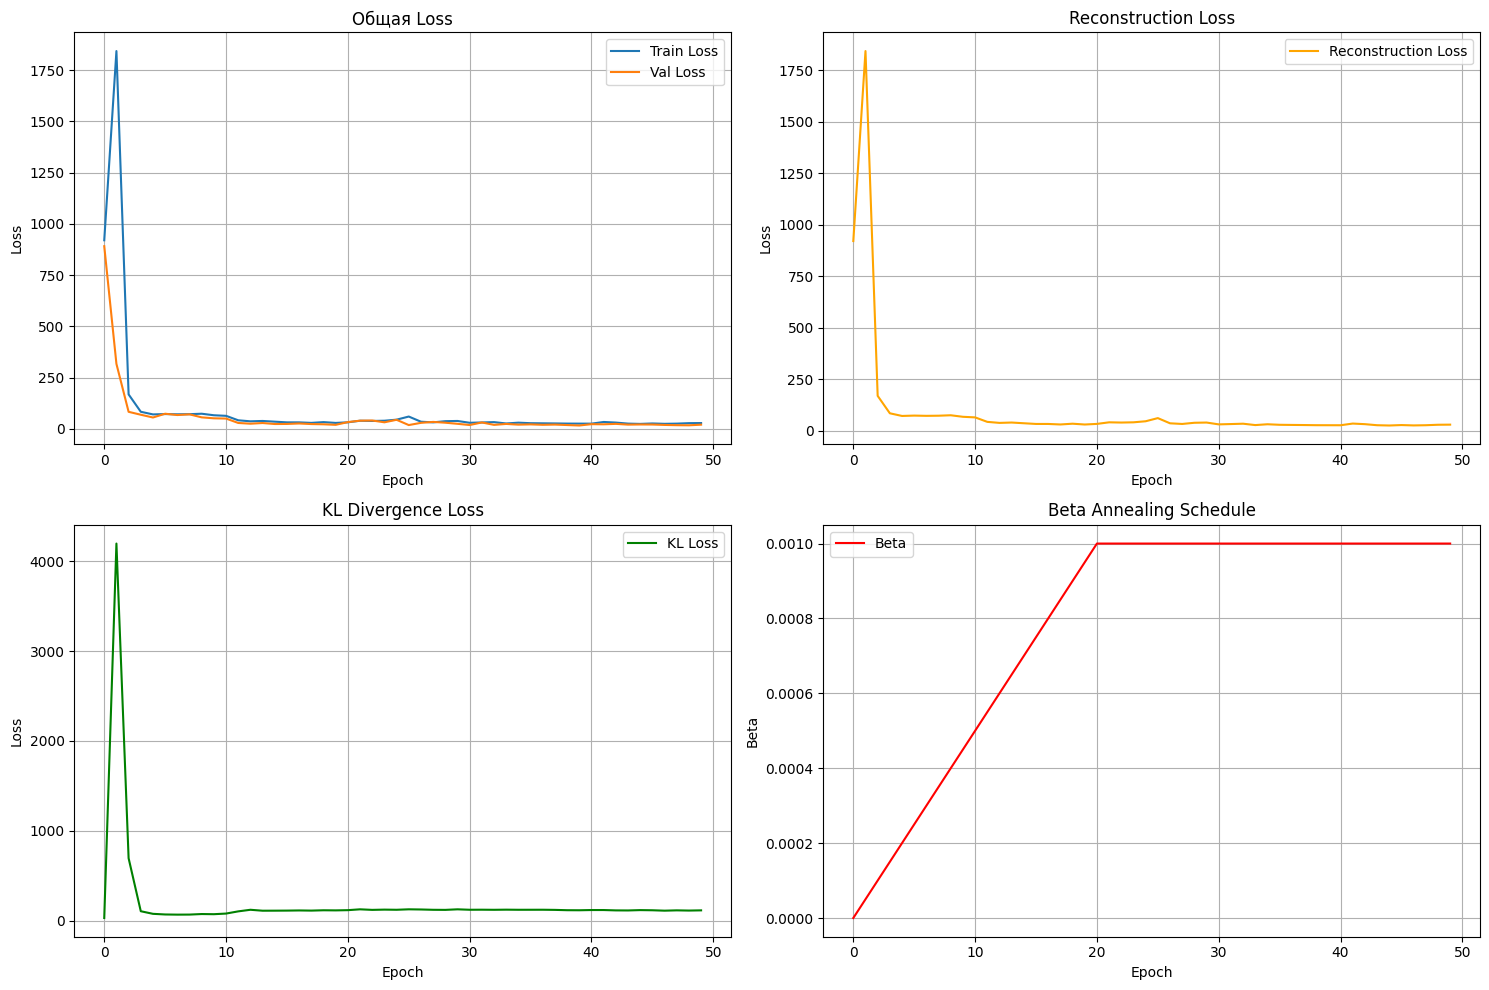


Обучение завершено!
Лучшая val loss: 16.8571
Модель сохранена в: models
Результаты сохранены в: results

Загрузка лучшей модели из models/best_model.pth

АНАЛИЗ ЛАТЕНТНОГО ПРОСТРАНСТВА


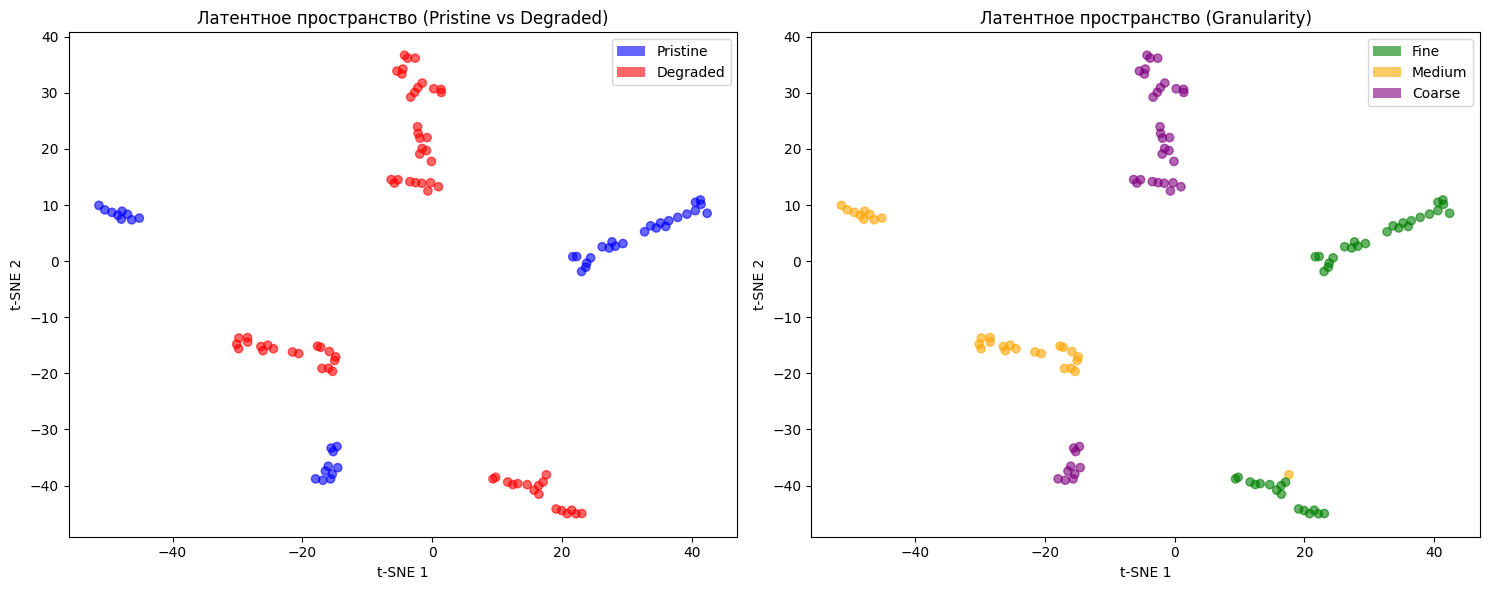

In [17]:
#ЗАПУСК
if torch.cuda.is_available():
    print(f"CUDA доступен: {torch.cuda.get_device_name(0)}")
    print(f"  Память GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("CUDA не доступен, используется CPU")

# Обновление конфигурации
config = CONFIG.copy()

# Автоматическая настройка batch_size в зависимости от памяти GPU
if torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    if gpu_memory < 4:  # Меньше 4GB
        config['batch_size'] = 2
        config['max_nodes'] = 30
    elif gpu_memory < 8:  # Меньше 8GB
        config['batch_size'] = 4
        config['max_nodes'] = 40
    else:  # Больше 8GB
        config['batch_size'] = 8
        config['max_nodes'] = 50

print(f"Конфигурация обучения:")
for key, value in config.items():
    if not isinstance(value, (list, dict)):
        print(f"  {key}: {value}")

# Запуск обучения

model, train_losses, val_losses = train_model(config)

# Загрузка лучшей модели для анализа
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model_path = Path(config['save_dir']) / 'best_model.pth'

if best_model_path.exists():
    print(f"\nЗагрузка лучшей модели из {best_model_path}")

    checkpoint = torch.load(best_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Создаём dataloader для всего датасета
    graph_triplets = Graph_triplets
    labels = Graph_labels

    dataset = AnodeGraphDataset(
        graph_triplets=graph_triplets,
        labels=labels,
        max_nodes=config['max_nodes'],
        node_dim=config['node_dim']
    )

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=min(config['batch_size'], len(dataset)),
        shuffle=False,
        collate_fn=collate_anode_graphs
    )

    # Анализ латентного пространства
    latent_vectors, labels_list = analyze_latent_space(
        model, dataloader, device, Path(config['results_dir']))